# Elementary Effects for the BTD Model

## Setup packages.

In [1]:
require(data.table)
require(magrittr)
require(sensitivity)

require(ggplot2)

Loading required package: data.table
Loading required package: magrittr
Loading required package: sensitivity
Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr
Loading required package: ggplot2


## Design experiment.

### Load input ranges.

In [ ]:
z.ranges <- fread("input-ranges.tsv")
z.ranges %>% dim

In [ ]:
z.ranges %>% summary

### One-at a time experiment with 500 repetitions, à la Morris.

In [ ]:
z.design <- morris(
    NULL,
    factors = z.ranges$Variable,
    r = 500,
    design = list(
        type = "oat",
        levels = mapply(function(t, x0, x1) {
            if (t == "Integer")
                x1 - x0 + 1
            else if (t == "Boolean")
                2
            else
                5
        }, z.ranges$Type, z.ranges$`Sensitivity Minimum`, z.ranges$`Sensitivity Maximum`),
        grid.jump = 1
    )
)
z.design$X %>% dim

In [ ]:
write.table(z.design$X, file = "design.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

### Relate the design to the model's variables.

In [ ]:
z.inputs <- cbind(
    Run = 1:(dim(z.design$X)[1]),
    data.table(
        sweep(
            sweep(z.design$X, MARGIN = 2, z.ranges$`Sensitivity Maximum` - z.ranges$`Sensitivity Minimum`, `*`),
            MARGIN = 2,
            z.ranges$`Sensitivity Minimum`,
            `+`
        )
    )
)
z.inputs %>% summary

In [ ]:
write.table(z.inputs, file="inputs.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

## Analyze results.

### Read files.

#### Read design.

In [2]:
z.design <- fread("design.tsv")
z.design %>% dim

[1] 42500    84

#### Read inputs.

In [3]:
z.inputs <- fread("inputs.tsv")
z.inputs %>% dim

[1] 42500    85

#### Read outputs.

In [4]:
z.outputs <- fread("outputs.tsv")
z.outputs[Time == 2050] %>% dim

[1] 42500    51

In [5]:
z.outputs[Time == 2050] %>% summary

      Run             Time      bioproduct market share mass
 Min.   :    1   Min.   :2050   Min.   :-27.65680           
 1st Qu.:10626   1st Qu.:2050   1st Qu.:  0.01149           
 Median :21250   Median :2050   Median :  0.33107           
 Mean   :21250   Mean   :2050   Mean   :  0.59533           
 3rd Qu.:31875   3rd Qu.:2050   3rd Qu.:  0.71766           
 Max.   :42500   Max.   :2050   Max.   : 54.99460           
 current market size economic current market size mass long term market share
 Min.   :-9.881e+13           Min.   :1.750e+04        Min.   :0.0000        
 1st Qu.:-2.500e+10           1st Qu.:2.069e+07        1st Qu.:0.2126        
 Median : 7.524e+10           Median :6.609e+07        Median :0.3172        
 Mean   : 3.949e+11           Mean   :2.866e+08        Mean   :0.3959        
 3rd Qu.: 5.717e+11           3rd Qu.:2.009e+08        3rd Qu.:0.5406        
 Max.   : 5.844e+13           Max.   :7.965e+09        Max.   :0.9810        
 long term market value    

### Compute elementary effects.

#### Just use the final year.

In [6]:
z.outputs.clean <- z.outputs[order(Run)][`Time` == 2050, c(-1, -2)] %>% as.matrix
z.outputs.clean %>% dim

[1] 42500    49

#### Define functions to compute elementary effects.

In [7]:
ind.rep <- function(i, p) {
# indices of the points of the ith trajectory in the DoE
  (1 : (p + 1)) + (i - 1) * (p + 1)
}

ee.oat <- function(X, y) {
  # compute the elementary effects for a OAT design
  p <- ncol(X)
  r <- nrow(X) / (p + 1)
  
#  if(is(y,"numeric")){
  if(inherits(y, "numeric")){
    one_i_vector <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      # return((y[j2] - y[j1]) / rowSums(X[j2,] - X[j1,]))
      return(solve(X[j2,] - X[j1,], y[j2] - y[j1]))
    }
    ee <- vapply(1:r, one_i_vector, FUN.VALUE = numeric(p))
    ee <- t(ee)
    # "ee" is now a (r times p)-matrix.
#  } else if(is(y,"matrix")){
  } else if(inherits(y, "matrix")){
    one_i_matrix <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      return(solve(X[j2,] - X[j1,], 
                   y[j2, , drop = FALSE] - y[j1, , drop = FALSE]))
    }
    ee <- vapply(1:r, one_i_matrix, 
                 FUN.VALUE = matrix(0, nrow = p, ncol = dim(y)[2]))
    # Special case handling for p == 1 and ncol(y) == 1 (in this case, "ee" is
    # a vector of length "r"):
    if(p == 1 && dim(y)[2] == 1){
      ee <- array(ee, dim = c(r, 1, 1))
    }
    # Transpose "ee" (an array of dimensions c(p, ncol(y), r)) to an array of
    # dimensions c(r, p, ncol(y)) (for better consistency with the standard 
    # case that "class(y) == "numeric""):
    ee <- aperm(ee, perm = c(3, 1, 2))
#  } else if(is(y,"array")){
  } else if(inherits(y, "array")){
    one_i_array <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      ee_per_3rd_dim <- sapply(1:(dim(y)[3]), function(idx_3rd_dim){
        y_j2_matrix <- y[j2, , idx_3rd_dim]
        y_j1_matrix <- y[j1, , idx_3rd_dim]
        # Here, the result of "solve(...)" is a (p times dim(y)[2])-matrix or
        # a vector of length dim(y)[2] (if p == 1):
        solve(X[j2,] - X[j1,], y_j2_matrix - y_j1_matrix)
      }, simplify = "array")
      if(dim(y)[2] == 1){
        # Correction needed if dim(y)[2] == 1, so "y_j2_matrix" and
        # "y_j1_matrix" have been dropped to matrices (or even vectors, if also
        # p == 1):
        ee_per_3rd_dim <- array(ee_per_3rd_dim, 
                                dim = c(p, dim(y)[2], dim(y)[3]))
      } else if(p == 1){
        # Correction needed if p == 1 (and dim(y)[2] > 1), so "y_j2_matrix" and
        # "y_j1_matrix" have been dropped to matrices:
        ee_per_3rd_dim <- array(ee_per_3rd_dim, 
                                dim = c(1, dim(y)[2], dim(y)[3]))
      }
      # "ee_per_3rd_dim" is now an array of dimensions 
      # c(p, dim(y)[2], dim(y)[3]). Assign the corresponding names for the 
      # third dimension:
      if(is.null(dimnames(ee_per_3rd_dim))){
        dimnames(ee_per_3rd_dim) <- dimnames(y)
      } else{
        dimnames(ee_per_3rd_dim)[[3]] <- dimnames(y)[[3]]
      }
      return(ee_per_3rd_dim)
    }
    ee <- sapply(1:r, one_i_array, simplify = "array")
    # Special case handling if "ee" has been dropped to a vector:
#    if(is(ee,"numeric")){
    if (inherits(ee, "numeric")){
      ee <- array(ee, dim = c(p, dim(y)[2], dim(y)[3], r))
      dimnames(ee) <- list(NULL, dimnames(y)[[2]], dimnames(y)[[3]], NULL)
    }
    # "ee" is an array of dimensions c(p, dim(y)[2], dim(y)[3], r), so it is
    # transposed to an array of dimensions c(r, p, dim(y)[2], dim(y)[3]):
    ee <- aperm(ee, perm = c(4, 1, 2, 3))
  }
  return(ee)
}

#### Elementary effects.

In [8]:
z.ee <- ee.oat(z.design, z.outputs.clean)
z.ee %>% dim

[1] 500  84  49

#### mu, mu*, and sigma.

In [9]:
z.mu <- apply(z.ee, 3, function(M){
  apply(M, 2, mean)
})
z.mu <- melt(
    cbind(
        data.table(Input=rownames(z.mu)),
        data.table(z.mu)
    ),
    id.vars="Input",
    variable.name = "Output",
    value.name = "mu"
)
z.mu %>% head

Input,Output,mu
<chr>,<fct>,<dbl>
advertising budget,bioproduct market share mass,0.303273857
advertising start time,bioproduct market share mass,-0.387986934
aversion to NPV deviation,bioproduct market share mass,-0.001418284
base external investor ask rate,bioproduct market share mass,-0.023685767
bioproduct long term price,bioproduct market share mass,-0.160606092
bioproduct offtake agreement,bioproduct market share mass,0.512129831


In [10]:
z.mu.star <- apply(abs(z.ee), 3, function(M){
  apply(M, 2, mean)
})
z.mu.star <- melt(
    cbind(
        data.table(Input=rownames(z.mu.star)),
        data.table(z.mu.star)
    ),
    id.vars="Input",
    variable.name = "Output",
    value.name = "mu*"
)
z.mu.star %>% head

Input,Output,mu*
<chr>,<fct>,<dbl>
advertising budget,bioproduct market share mass,0.31027692
advertising start time,bioproduct market share mass,0.41195148
aversion to NPV deviation,bioproduct market share mass,0.01152693
base external investor ask rate,bioproduct market share mass,0.26447606
bioproduct long term price,bioproduct market share mass,0.39980623
bioproduct offtake agreement,bioproduct market share mass,0.77572582


In [11]:
z.sigma <- apply(z.ee, 3, function(M){
  apply(M, 2, sd)
})
z.sigma <- melt(
    cbind(
        data.table(Input=rownames(z.sigma)),
        data.table(z.sigma)
    ),
    id.vars="Input",
    variable.name = "Output",
    value.name = "sigma"
)
z.sigma %>% head

Input,Output,sigma
<chr>,<fct>,<dbl>
advertising budget,bioproduct market share mass,1.1085135
advertising start time,bioproduct market share mass,1.4664525
aversion to NPV deviation,bioproduct market share mass,0.1115146
base external investor ask rate,bioproduct market share mass,0.6278341
bioproduct long term price,bioproduct market share mass,1.7387415
bioproduct offtake agreement,bioproduct market share mass,4.5942430


In [12]:
z.results <- merge(merge(z.mu, z.mu.star, on=c("Input", "Output")), z.sigma, on=c("Input", "Output"))
z.results %>% head

Input,Output,mu,mu*,sigma
<chr>,<fct>,<dbl>,<dbl>,<dbl>
advertising budget,bioproduct market share mass,3.032739e-01,3.102769e-01,1.108513e+00
advertising budget,current market size economic,-2.412707e+11,9.415770e+11,4.866741e+12
advertising budget,current market size mass,0.000000e+00,0.000000e+00,0.000000e+00
advertising budget,long term market share,-6.742848e-04,1.255821e-03,1.507683e-02
advertising budget,long term market value,-3.252294e+08,3.252294e+08,7.252179e+09
advertising budget,Adopters,4.651019e+07,5.092098e+07,1.587423e+08


In [13]:
z.results[, `:=`(
    `mu rank`    = frank(- `mu`   ),
    `mu* rank`   = frank(- `mu*`  ),
    `sigma rank` = frank(- `sigma`)
), by=.(Output)]
z.results %>% head

Input,Output,mu,mu*,sigma,mu rank,mu* rank,sigma rank
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
advertising budget,bioproduct market share mass,3.032739e-01,3.102769e-01,1.108513e+00,3,15,24
advertising budget,current market size economic,-2.412707e+11,9.415770e+11,4.866741e+12,80,23,25
advertising budget,current market size mass,0.000000e+00,0.000000e+00,0.000000e+00,43,44,44
advertising budget,long term market share,-6.742848e-04,1.255821e-03,1.507683e-02,64,49,51
advertising budget,long term market value,-3.252294e+08,3.252294e+08,7.252179e+09,71,30,24
advertising budget,Adopters,4.651019e+07,5.092098e+07,1.587423e+08,6,13,23


### Interpret results.

Interpretations:
*   mu: influence of variable
*   mustar: influence of variable, accounting for non-monoticity
*   sigma: non-linear and interaction effects for variable

#### Heat map for mu*.

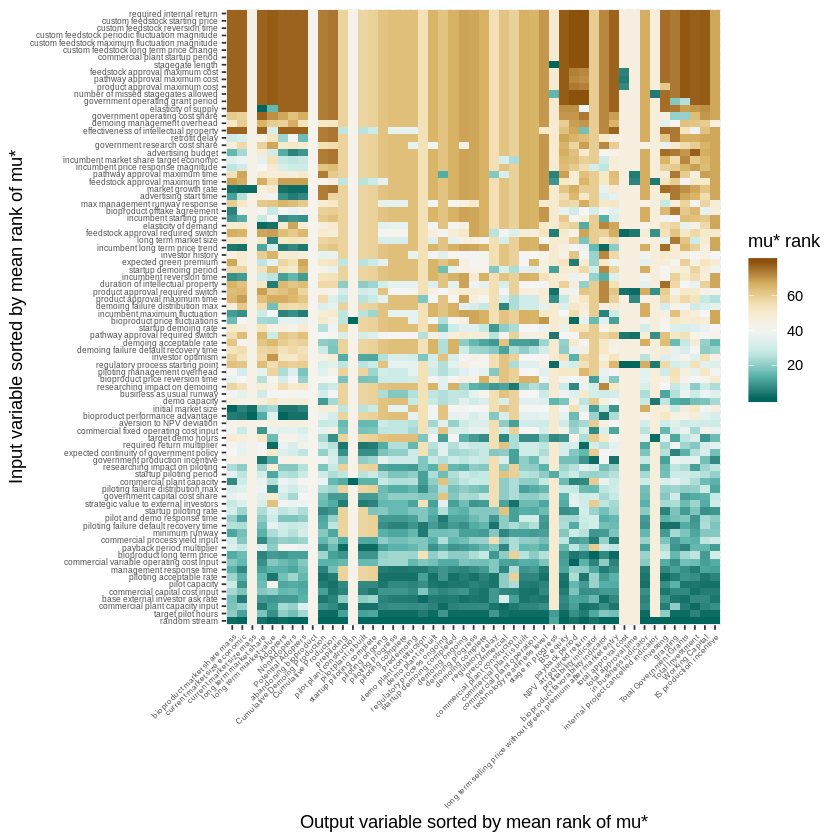

In [14]:
ggplot(
    z.results,
    aes(
        x=factor(
            Output,
            levels=z.results[, .(`sort` = mean(`mu* rank`)), by=.(Output)][order(sort), `Output`]
        ),
        y=factor(
            Input,
            levels=z.results[, .(`sort` = mean(`mu* rank`)), by=.(Input)][order(sort), `Input`]
        ),
        fill=`mu* rank`
    )
) +
    geom_tile() +
    scale_fill_distiller(type="div") +
    xlab("Output variable sorted by mean rank of mu*") +
    ylab("Input variable sorted by mean rank of mu*") +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

#### Heat map for sigma.

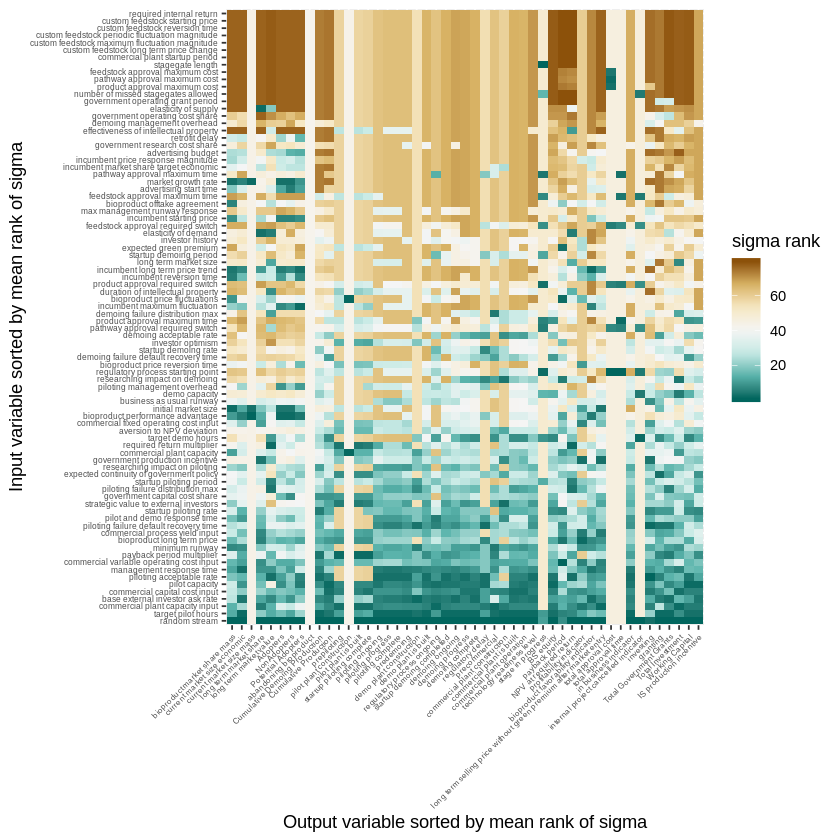

In [15]:
ggplot(
    z.results,
    aes(
        x=factor(
            Output,
            levels=z.results[, .(`sort` = mean(`sigma rank`)), by=.(Output)][order(sort), `Output`]
        ),
        y=factor(
            Input,
            levels=z.results[, .(`sort` = mean(`sigma rank`)), by=.(Input)][order(sort), `Input`]
        ),
        fill=`sigma rank`
    )
) +
    geom_tile() +
    scale_fill_distiller(type="div") +
    xlab("Output variable sorted by mean rank of sigma") +
    ylab("Input variable sorted by mean rank of sigma") +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

#### Box plots of ranks for mu*.

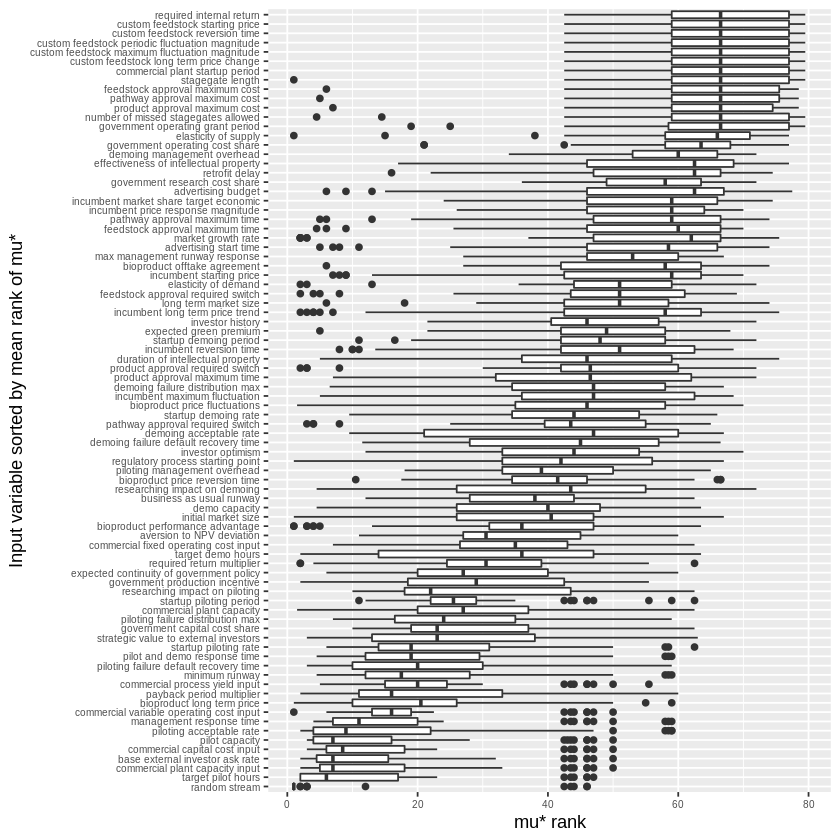

In [16]:
ggplot(
    z.results,
    aes(
        x=factor(
            Input,
            levels=z.results[, .(`sort` = mean(`mu* rank`)), by=.(Input)][order(sort), `Input`]
        ),
        y=`mu* rank`
    )
) +
    geom_boxplot() +
    coord_flip() +
    xlab("Input variable sorted by mean rank of mu*") +
    theme(axis.text=element_text(size=6))

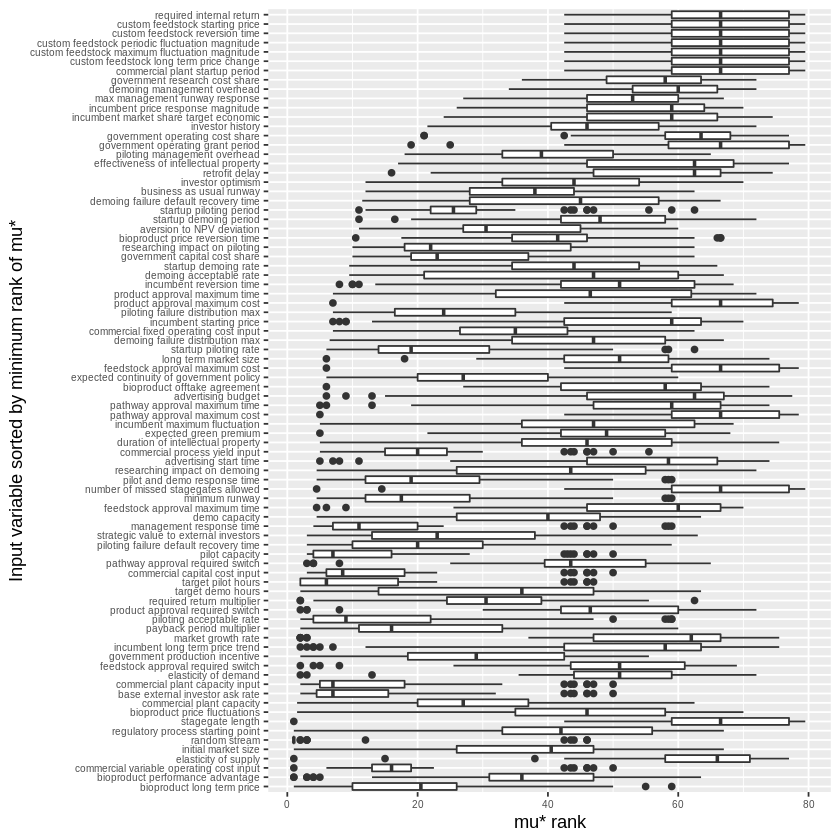

In [17]:
ggplot(
    z.results,
    aes(
        x=factor(
            Input,
            levels=z.results[, .(`sort` = min(`mu* rank`)), by=.(Input)][order(sort), `Input`]
        ),
        y=`mu* rank`
    )
) +
    geom_boxplot() +
    coord_flip() +
    xlab("Input variable sorted by minimum rank of mu*") +
    theme(axis.text=element_text(size=6))

#### Box plots of ranks for sigma.

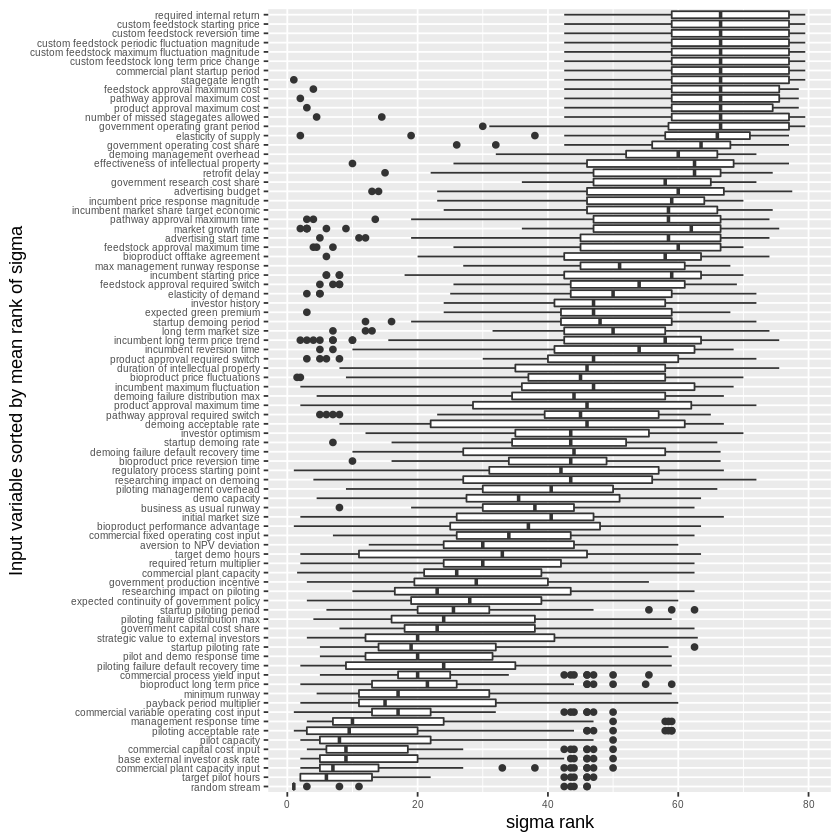

In [18]:
ggplot(
    z.results,
    aes(
        x=factor(
            Input,
            levels=z.results[, .(`sort` = mean(`sigma rank`)), by=.(Input)][order(sort), `Input`]
        ),
        y=`sigma rank`
    )
) +
    geom_boxplot() +
    coord_flip() +
    xlab("Input variable sorted by mean rank of sigma") +
    theme(axis.text=element_text(size=6))

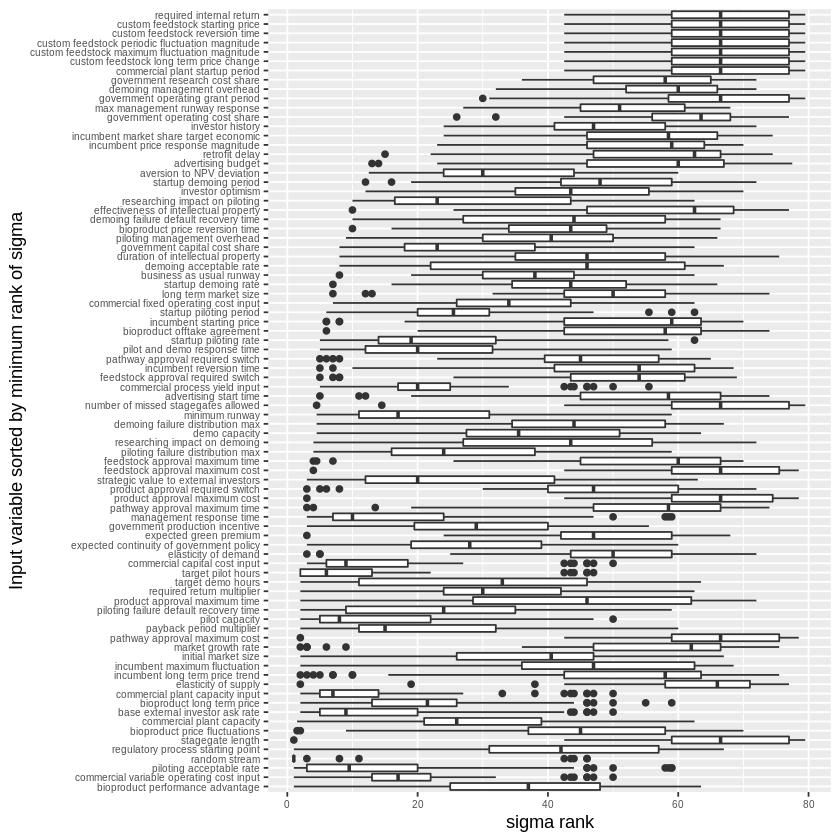

In [19]:
ggplot(
    z.results,
    aes(
        x=factor(
            Input,
            levels=z.results[, .(`sort` = min(`sigma rank`)), by=.(Input)][order(sort), `Input`]
        ),
        y=`sigma rank`
    )
) +
    geom_boxplot() +
    coord_flip() +
    xlab("Input variable sorted by minimum rank of sigma") +
    theme(axis.text=element_text(size=6))

### Select inputs variables for variance-based sensitivity analysis.

#### Select the variables whose median rank is less than 30.

In [20]:
z.results[,
    .(
        `mu* minimum rank`   = min   (`mu* rank`),
        `mu* mean rank`      = mean  (`mu* rank`),
        `mu* median rank`    = median(`mu* rank`),
        `sigma minimum rank` = min   (`sigma rank`),
        `sigma mean rank`    = mean  (`sigma rank`),
        `sigma median rank`  = median(`sigma rank`)
    ),
    by=.(Input)
][order(`mu* median rank`)][
    `mu* median rank` <= 30 | `sigma median rank` <= 30
]

Input,mu* minimum rank,mu* mean rank,mu* median rank,sigma minimum rank,sigma mean rank,sigma median rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
random stream,1.0,5.816327,1.0,1.0,5.816327,1.0
target pilot hours,2.0,11.948980,6.0,2.0,11.775510,6.0
base external investor ask rate,2.0,13.744898,7.0,2.0,14.755102,9.0
commercial plant capacity input,2.0,13.673469,7.0,2.0,14.428571,7.0
pilot capacity,3.0,14.632653,7.0,2.0,15.285714,8.0
commercial capital cost input,3.0,14.326531,8.5,3.0,15.173469,9.0
piloting acceptable rate,2.0,17.908163,9.0,1.0,17.826531,9.5
management response time,4.0,18.091837,11.0,3.0,18.897959,10.0
commercial variable operating cost input,1.0,19.183673,16.0,1.0,20.000000,17.0


#### Since production is the most important output, check the ranks for that.

In [21]:
z.results[Output == "Cumulative Production"][order(`mu* rank`)]

Input,Output,mu,mu*,sigma,mu rank,mu* rank,sigma rank
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
random stream,Cumulative Production,-940470.13,15393209.2,100494557,83,1,1
target pilot hours,Cumulative Production,-3423993.41,3902968.9,21377483,84,2,4
pilot capacity,Cumulative Production,-170879.34,3598234.2,23100902,72,3,2
commercial capital cost input,Cumulative Production,1125500.14,3150768.6,21928963,4,4,3
piloting acceptable rate,Cumulative Production,78101.40,2604742.6,16174465,17,5,6
base external investor ask rate,Cumulative Production,691010.42,2506264.6,16827901,7,6,5
commercial plant capacity input,Cumulative Production,1636623.64,2101824.9,15772556,1,7,7
target demo hours,Cumulative Production,70952.60,1868923.5,15558456,18,8,8
startup piloting rate,Cumulative Production,1545903.95,1793046.6,12786463,2,9,13


#### Format results for a github issue.

In [22]:
options(repr.matrix.max.rows=100)
z.results[,
    .(
        `mu* minimum rank`   = min   (`mu* rank`),
        `mu* mean rank`      = mean  (`mu* rank`),
        `mu* median rank`    = median(`mu* rank`),
        `sigma minimum rank` = min   (`sigma rank`),
        `sigma mean rank`    = mean  (`sigma rank`),
        `sigma median rank`  = median(`sigma rank`)
    ),
    by=.(Input)
][order(`mu* median rank`)][,
    .(
        text=mapply(
            function(x, y) paste(ifelse(x, "- [x]", "- [ ]"), y),
            `mu* median rank` <= 30 | `sigma median rank` <= 30,
            Input
        )
            
    )
]

text
<chr>
- [x] random stream
- [x] target pilot hours
- [x] base external investor ask rate
- [x] commercial plant capacity input
- [x] pilot capacity
- [x] commercial capital cost input
- [x] piloting acceptable rate
- [x] management response time
- [x] commercial variable operating cost input
